<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/clusters/workflow_unsupervised_learning_clusteripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install Faker
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Descripción**
---

El presente proyecto tiene como objetivo mostrar un flujo de trabajo aplicando aprendizaje no supervisado, desde el preprocesamiento, pasando por la modelación y descripción de cada segmento. Pese a que se uso un conjunto de datos ficticios, este proceso es aplicable para datos y entornos reales.

In [3]:
# -- data faker --
from datetime import date, datetime
from random import randint, sample, choices
from faker.providers.address import es_CO as co_provider
from faker.providers.ssn import es_CO as co_ssn


import random
from matplotlib.colors import ListedColormap



# -- data --
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder 

# -- graficos --
import matplotlib.pyplot as plt
import seaborn as sns


# --models
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.cluster import KMeans, BisectingKMeans

from sklearn.metrics import silhouette_score

In [4]:
random.seed(42)

# **Data generator**

In [5]:
# Date generator

seed = 1000

def generate_date(start_year):
  start_date = datetime(start_year, 1, 1).replace(day=1, month=1).toordinal()
  end_date = date.today().toordinal()
  date_gen = date.fromordinal(randint(start_date, end_date))
  return date_gen.isoformat()


date_fake = list(map(lambda x: generate_date(2022), range(0,seed)))
date_fake.sort(key=lambda date: datetime.strptime(date, "%Y-%m-%d"))

In [6]:
# Money generator
money = sample(list(range(500000, 10000000)),seed)

In [7]:
# Jurisdiction generator
jurisdicciones = list(map(lambda x: choices(list(co_provider.Provider.departments.values()))[0], range(seed)))

In [8]:
# Generador cedula
nit = [1416184,15616515,151178,95959,15151,77474,1616,848489,11818941,118918941,16447496,6164684,16184,618484,14894,6519618,7474984,1313185168,18479841,161798,1747894,9559,141616,89746468,48484,16516,747087,1618,789965,651681,164894,651981,198189,198198,198198,1984198,1981891,498498,262945]
nit = list(map(lambda x: choices(list(nit))[0], range(seed)))

In [9]:
data = pd.DataFrame()
data['nit'] = nit
data['date'] = date_fake
data['money'] = money
data['jurisdictions'] = jurisdicciones

# **Functions**
---
They are hidden to reduce the cognitive load of the code.

In [10]:
def plot_select_params(best_score, best_x_param, scores, x_params, **kwards):
  fig, ax = plt.subplots(1, 1, figsize=(8, 5))
  ax.plot(x_params, scores)
  ax.plot(best_x_param, best_score, marker='o', color='r')
  ax.axvline(x=best_x_param,  color='r')
  ax.set_title(kwards['title'])
  ax.set_xlabel(kwards['xlabel'])
  ax.set_ylabel(kwards['ylabel'])


def silhouette_select_cluster(model, clusters, data, **kwards):
  """Metodo silhouette"""
  range_n_clusters = range(clusters[0], clusters[1])
  valores_medios_silhouette = {}
  for k in range_n_clusters:
    model.n_clusters = k 
    model.fit(data)
    y_predict = model.predict(data)
    silhouette_avg = silhouette_score(data, y_predict)
    valores_medios_silhouette[k] = silhouette_avg
  
  x = list(range_n_clusters)
  y = list(valores_medios_silhouette.values())
  kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")

  best_score = valores_medios_silhouette[kneedle.elbow]
  best_cluster = kneedle.elbow

  res_data = {
      'score': best_score,
      'cluster': best_cluster,
  }
  plot_select_params(best_score, best_cluster, y, range_n_clusters,
                        title = f'Evolución de media de los índices silhouette {kwards["name_model"]}',
                        ylabel = 'Media índices silhouette',
                        xlabel = 'Numero clusters')
  
  return best_cluster, best_score


def pie_circle(serie:pd.Series, paleta=None, figsize_x:int=7, figsize_y:int=7,fontsize=15,**kwards)->None:
  paleta = paleta if paleta !=None else generate_colors()[0]
  values = serie.value_counts().sort_index()
  names = values.index
  size = values.values
  fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
  fig.suptitle(f'Diagrama de anillo {kwards["title"]}', fontsize=fontsize)
  my_circle = plt.Circle( (0,0), 0.7, color='white')
  plt.pie(size, labels=names, autopct="%0.1f %%", wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors = paleta)
  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()



def generate_colors(paleta="Set1", n_colors=15):
  """Generador de colores"""
  cmap = sns.color_palette(paleta, n_colors).as_hex()
  list_camap = ListedColormap(cmap)
  return cmap, list_camap

# **DATA**
---

In [11]:
data.head()

,nit,date,money,jurisdictions
0,14894,2022-01-01,8390439,Santander
1,77474,2022-01-01,825197,Quindío
2,6519618,2022-01-01,9549949,Valle del Cauca
3,89746468,2022-01-02,1373851,Córdoba
4,141616,2022-01-02,6371360,Antioquia


In [12]:
# Change data type date
data['date'] = data['date'].astype('datetime64[ns]')

In [13]:
# Extraction of the year and month
data['year'] = data['date'].apply(lambda x: x.year)
data['month'] = data['date'].apply(lambda x: x.month)

In [14]:
# First grouping
# Group by nit, year and month
data_group = data.groupby(["year", "month", "nit"]).agg({'month': ['count', 'mean'], 'money': ['sum', 'mean']})

In [15]:
data_group_pos = pd.DataFrame(data_group.values)
data_group_pos.index = data_group.index
data_group_pos.reset_index(inplace=True)

In [16]:
data_group_pos.columns = ['year', 'month_active', 'nit', 'number_transactions', 'number_transactions_average_month', 'amount', 'amountXmonth']
data_group_pos.head()

,year,month_active,nit,number_transactions,number_transactions_average_month,amount,amountXmonth
0,2022,1,1616,3.0,1.0,5617448.0,1.872483e+06
1,2022,1,1618,1.0,1.0,5718367.0,5.718367e+06
2,2022,1,9559,3.0,1.0,16032926.0,5.344309e+06
3,2022,1,14894,2.0,1.0,13189494.0,6.594747e+06
4,2022,1,16516,2.0,1.0,11088349.0,5.544174e+06


In [17]:
# Example of grouping for a single example
data_group_pos[data_group_pos["nit"] == 11818941]

,year,month_active,nit,number_transactions,number_transactions_average_month,amount,amountXmonth
24,2022,1,11818941,3.0,1.0,16477182.0,5.492394e+06
57,2022,2,11818941,1.0,2.0,8299287.0,8.299287e+06
88,2022,3,11818941,2.0,3.0,10333398.0,5.166699e+06
118,2022,4,11818941,4.0,4.0,18236884.0,4.559221e+06
152,2022,5,11818941,1.0,5.0,8594999.0,8.594999e+06
185,2022,6,11818941,2.0,6.0,3911315.0,1.955658e+06
211,2022,7,11818941,2.0,7.0,9152278.0,4.576139e+06
304,2022,10,11818941,2.0,10.0,3649276.0,1.824638e+06
334,2022,11,11818941,2.0,11.0,6156797.0,3.078398e+06
365,2022,12,11818941,1.0,12.0,3543480.0,3.543480e+06


In [18]:
data_group_pos.columns

Index(['year', 'month_active', 'nit', 'number_transactions',
       'number_transactions_average_month', 'amount', 'amountXmonth'],
      dtype='object')

In [19]:
# First grouping
# Group by nit
data_groupII = data_group_pos.groupby(["nit"]).agg({'number_transactions': ['count', 'sum', 'mean'], 'amount': ['sum', 'mean']})
data_group_posII = pd.DataFrame(data_groupII.values)
data_group_posII.index = data_groupII.index
data_group_posII.reset_index(inplace=True)

In [20]:
data_group_posII.columns = ['nit', 'month_active', 'number_transactions', 'number_transactions_average_month', 'amount', 'amountXmonth']
data_group_posII.head()

,nit,month_active,number_transactions,number_transactions_average_month,amount,amountXmonth
0,1616,15.0,28.0,1.866667,127283170.0,8.485545e+06
1,1618,16.0,27.0,1.687500,130526971.0,8.157936e+06
2,9559,14.0,23.0,1.642857,143819604.0,1.027283e+07
3,14894,13.0,26.0,2.000000,150196704.0,1.155359e+07
4,15151,13.0,26.0,2.000000,132165984.0,1.016661e+07


In [21]:
# Example of grouping for a second example
data_group_posII[data_group_posII["nit"] == 11818941]

,nit,month_active,number_transactions,number_transactions_average_month,amount,amountXmonth
31,11818941,14.0,34.0,2.428571,145248615.0,1.037490e+07


- The client 11818941 was active for 12 months, where he made 20 transactions

# **Models**
---

Select features
- month_active
- number_transactions
- number_transactions_average_month
- amount
- valorXmes


Let´s Supongamos that we have a risk variable, related to the jurisdictions or states
- risk

In [22]:
risk = list(map(lambda x: choices(['High', 'Medium', 'Low'])[0], range(data_group_posII.shape[0])))

In [23]:
data_group_posII['risk'] = risk
data_group_posII

,nit,month_active,number_transactions,number_transactions_average_month,amount,amountXmonth,risk
0,1616,15.0,28.0,1.866667,127283170.0,8.485545e+06,High
1,1618,16.0,27.0,1.687500,130526971.0,8.157936e+06,Medium
2,9559,14.0,23.0,1.642857,143819604.0,1.027283e+07,Medium
3,14894,13.0,26.0,2.000000,150196704.0,1.155359e+07,Low
4,15151,13.0,26.0,2.000000,132165984.0,1.016661e+07,Low
5,16184,15.0,26.0,1.733333,142977768.0,9.531851e+06,High
6,16516,14.0,28.0,2.000000,143690648.0,1.026362e+07,Low
7,48484,14.0,28.0,2.000000,149962519.0,1.071161e+07,Low
8,77474,15.0,28.0,1.866667,154182427.0,1.027883e+07,Medium
9,95959,13.0,30.0,2.307692,155627471.0,1.197134e+07,Medium


In [24]:
data_group_posII['risk'] = data_group_posII['risk'].replace({'High':3, 'Medium': 2, 'Low':1})

In [25]:
# KMeans
model = KMeans(init = "k-means++", n_init = 10, max_iter = 300, random_state = 42, algorithm = 'lloyd')

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
# Data Split
X = data_group_posII.iloc[:, 1:]
estimator = StandardScaler()
data_estandarizada = estimator.fit_transform(X)
X = data_estandarizada

(5, 0.3017898960297127)

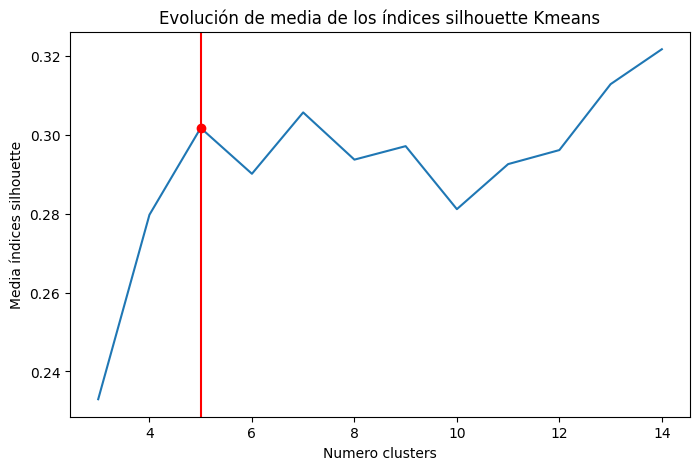

In [28]:
silhouette_select_cluster(model, (3,15), X, name_model = 'Kmeans')

In [29]:
model = BisectingKMeans(init='random', random_state=42, max_iter=300, algorithm="lloyd", bisecting_strategy="biggest_inertia")

(4, 0.2691634973303345)

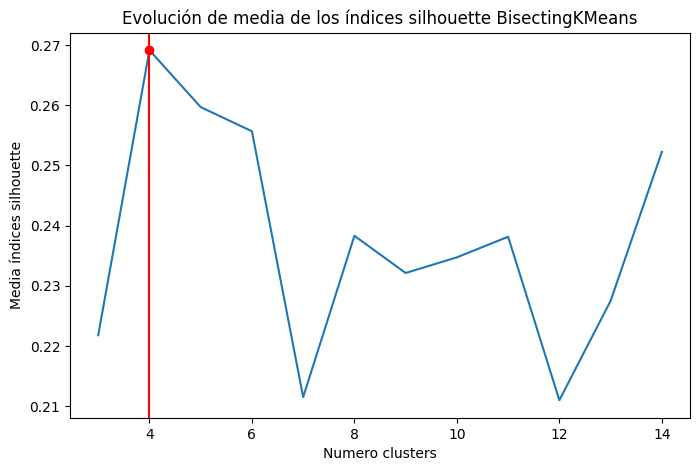

In [30]:
silhouette_select_cluster(model, (3,15), X, name_model = 'BisectingKMeans')

# **`Si bien no es un coeficiente óptimo, se seleccionará el Kmeans de cinco segmentos para efectos del proceso.`**

In [31]:
model_k = KMeans(n_clusters=5, init = "k-means++", n_init = 10, max_iter = 300, random_state = 42, algorithm = 'lloyd')
segmento = model_k.fit_predict(X)
data_group_posII["segmento"] = segmento

In [32]:
silhouette_score(X, segmento)

0.3017898960297127

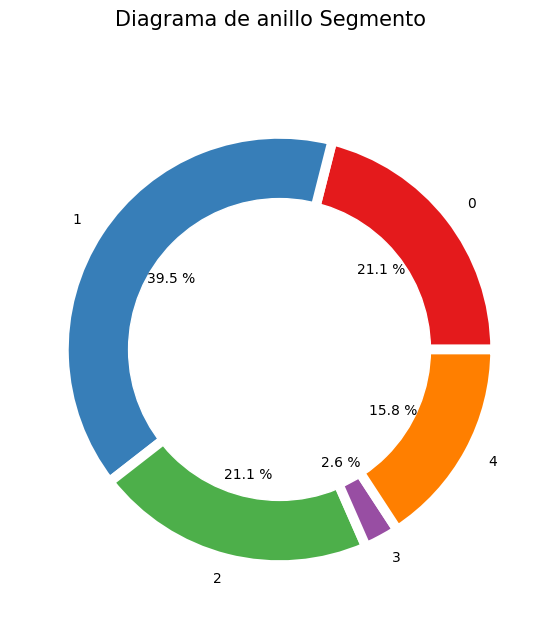

In [33]:
pie_circle(data_group_posII['segmento'], paleta=None, title='Segmento')

In [34]:
pd.options.display.float_format = '{:.2f}'.format

In [49]:
data_group_posII[data_group_posII['segmento'] == 4].describe()

,nit,month_active,number_transactions,number_transactions_average_month,amount,amountXmonth,risk,segmento
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,35596129.00,13.33,21.33,1.61,104197954.17,7898907.88,1.00,4.00
std,54040908.58,1.37,1.51,0.16,15050638.10,1439679.64,0.00,0.00
min,198189.00,11.00,20.00,1.40,87312260.00,6033770.40,1.00,4.00
25%,1055788.00,13.00,20.25,1.51,91847794.25,6727433.32,1.00,4.00
50%,1983044.50,13.50,21.00,1.62,103991668.50,8411975.03,1.00,4.00
75%,67805900.50,14.00,21.75,1.71,114127571.50,8692690.49,1.00,4.00
max,118918941.00,15.00,24.00,1.82,124586086.00,9583545.08,1.00,4.00


In [51]:
dta_desc_example = data_group_posII[data_group_posII['segmento'] == 4]
dta_desc_example['risk'].value_counts()/dta_desc_example.shape[0]

1   1.00
Name: risk, dtype: float64

Los valores cuantitativos serán en terminos de promedios.

En el segmento cero hay ocho clientes, los cuales estuvieron activos durante 15 meses, en donde realizaron en promedio un total de 26 transacciones por un monto de 136483340.12, en el periodo de actividad, donde por cada mes se hicieron dos transacciones por un monto de 9229958.38. Donde el 62% de los clientes son de riesgo 2(Medio) y el 38% riesgo 3 (Alto).

En el segmento uno hay 15 clientes, los cuales estuvieron activos durante 13 meses, en donde realizaron en promedio un total de 29 transacciones por un monto de 153808861.13, en el periodo de actividad, donde por cada mes se hicieron dos transacciones por un monto de 11768544.99. Donde el 60% de los clientes son de riesgo 1(Bajo) y el 40% riesgo 2(Medio).

En el segmento dos hay 8 clientes, los cuales estuvieron activos durante 12 meses, en donde realizaron en promedio un total de 21 transacciones por un monto de 118359100.25, en el periodo de actividad, donde por cada mes se hicieron dos transacciones por un monto de 10157696.32. Donde el 88% de los clientes son de riesgo 3(Alto) y el 12% riesgo 2(Medio).

En el segmento tres hay 1 cliente, los cuales estuvieron activos durante 16 meses, en donde realizaron en promedio un total de 60 transacciones por un monto de 347937602.00, en el periodo de actividad, donde por cada mes se hicieron 4 transacciones por un monto de 21746100.12. Donde el 100% de riesgo 1(Bajo).

En el segmento cuatro hay 6 clientes, los cuales estuvieron activos durante 13 meses, en donde realizaron en promedio un total de 21 transacciones por un monto de 104197954.17, en el periodo de actividad, donde por cada mes se hicieron 2 transacciones por un monto de 7898907.88. Donde el 100% de riesgo 1(Bajo).

# **NOTAS**
---

- Recordemos que son datos creados con lógica, pero aleatoriamente, por lo tanto, es posible que la coherencia no sea la mejor, sobre todo en la variable de riesgo. Pero el punto del proyecto era recrear un flujo de trabajo en aprendizaje no supervisado.